# Data Visualization and Analysis
The goal of this notebook is to analyze and visualize "The Movies" dataset from Kaggle. We will try to get a better understanding of how our features relate, what components are most important, and how we can visualize some of the interesting pheneomena of the dataset. 

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

## Movie Metadata Analysis

In [2]:
# Load data for all movies
movie_titles = pd.read_csv('movies_metadata.csv', low_memory=False)

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(45466, 24)


adult belongs_to_collection    budget                          genres  \
36400  False                   NaN         0                              []   
22449  False                   NaN  12000000   [{'id': 18, 'name': 'Drama'}]   
25307  False                   NaN         0                              []   
36218  False                   NaN         0  [{'id': 35, 'name': 'Comedy'}]   
29730  False                   NaN         0   [{'id': 18, 'name': 'Drama'}]   

      homepage      id    imdb_id original_language  \
36400      NaN  151062  tt0104787                en   
22449      NaN  245775  tt2707858                fr   
25307      NaN  171357  tt2722780                en   
36218      NaN  332709  tt4571838                it   
29730      NaN  173911  tt1567279                en   

                    original_title  \
36400              Mad at the Moon   
22449           Yves Saint Laurent   
25307  Jonathan Rosenbaum, Present   
36218          Ho ucciso Napoleone   
29730                     Bluebird   

                                                overview  ... release_date  \
36400  A young woman on the frontier marries a meek f...  ...   1992-09-16   
22449  A look at the life of French designer Yves Sai...  ...   2014-01-08   
25307  A portrait of the influential American film cr...  ...   2013-02-27   
36218  In the space of twenty-four hours the life of ...  ...   2015-03-26   
29730  On a freezing January evening, school bus driv...  ...   2014-02-27   

          revenue runtime                                   spoken_languages  \
36400         0.0    98.0           [{'iso_639_1': 'en', 'name': 'English'}]   
22449  21026290.0   106.0  [{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...   
25307         0.0    13.0           [{'iso_639_1': 'en', 'name': 'English'}]   
36218         0.0    90.0          [{'iso_639_1': 'it', 'name': 'Italiano'}]   
29730         0.0    90.0           [{'iso_639_1': 'en', 'name': 'English'}]   

         status                                   tagline  \
36400  Released  When the moon rises, the howling begins.   
22449  Released          Fashions fade. Style is forever.   
25307  Released                                       NaN   
36218  Released                                       NaN   
29730  Released                                       NaN   

                             title  video vote_average vote_count  
36400              Mad at the Moon  False         10.0        1.0  
22449           Yves Saint Laurent  False          6.4      270.0  
25307  Jonathan Rosenbaum, Present  False          0.0        0.0  
36218            I Killed Napoleon  False          5.2       28.0  
29730                     Bluebird  False          6.3       10.0  

[5 rows x 24 columns]

In [3]:
# drop movies with no release date
movie_titles = movie_titles.dropna(subset=['release_date'])

# strip release_date to just year and aggregate by decade
movie_titles['release_date'] = pd.to_datetime(movie_titles['release_date'], errors='coerce')
movie_titles['year'] = movie_titles['release_date'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
movie_titles['year'] = pd.to_numeric(movie_titles['year'], errors='coerce')
movie_titles['decade'] = movie_titles['year'].apply(lambda x: str(((x-1900)//10)*10 + 1900) + "'s" if x != np.nan else np.nan)

# create pie chart of movie decades - and label the percentages
movie_decades = movie_titles['decade'].value_counts().to_frame().reset_index()
movie_decades.columns = ['decade', 'count']
movie_decades['percent'] = movie_decades['count'].apply(lambda x: 100*x/sum(movie_decades['count']))
movie_decades = movie_decades.sort_values('decade')
# plot pie chart
labels = movie_decades['decade'].tolist()
values = movie_decades['percent'].tolist()
trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Distribution of Movies by Decade')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Recency bias seems to be prevalent in our dataset - with the overwhelming majority of movies being listed from the current century. 

In [4]:
def extract_name_values(x):
    try:
        if isinstance(x, str):
            parsed_data = eval(x)
            if isinstance(parsed_data, list):
                return [i['name'] for i in parsed_data if isinstance(i, dict) and 'name' in i]
            else:
                return parsed_data['name']
    except:
        pass
    return np.nan

movie_titles['genres'] = movie_titles['genres'].apply(extract_name_values)

# create bar chart of movie genres - first we need to one hot encode the genres
# get a list of all genres
genres = set()
for i in movie_titles['genres']:
    # each row is a list
    if isinstance(i, list):
        for j in i:
            genres.update([j])
print('There are {} genres in the dataset.'.format(len(genres)))


There are 32 genres in the dataset.


In [5]:
# visualize the distribution of genres
# one hot encode the genres
for genre in genres:
    movie_titles[genre] = movie_titles['genres'].apply(lambda x: 1 if genre in x else 0)
# aggregate by genre
genre_counts = movie_titles[genres].sum().sort_values(ascending=False)
# plot bar chart
trace = go.Bar(x=genre_counts.index, y=genre_counts.values)
layout = go.Layout(title='Distribution of Movies by Genre')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

C:\Users\laith\AppData\Local\Temp\ipykernel_22188\2278570935.py:6: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



Here it seems like some misinformation has been plugged into the genre category, particularly with the production company name being inputted instead.

In [11]:
# see how many genres only have 1 movie
print('There are {} genres that only have 1 movie.'.format(len(genre_counts[genre_counts == 1])))

There are 12 genres that only have 1 movie.


In [12]:
# remove genres that only have 1 movie and replot
genre_counts = genre_counts[genre_counts > 1]
trace = go.Bar(x=genre_counts.index, y=genre_counts.values)
layout = go.Layout(title='Distribution of Movies by Genre')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [10]:
# analyze how much missing data there is
missing_data = movie_titles.isnull().sum().to_frame().reset_index()
missing_data.columns = ['column', 'count']
missing_data['percent'] = missing_data['count'].apply(lambda x: 100*x/len(movie_titles))
missing_data = missing_data.sort_values('percent', ascending=False)
# print out the top 10 columns with the most missing data
missing_data.head(10)

column  count    percent
1   belongs_to_collection  40888  90.103352
4                homepage  37610  82.879746
19                tagline  24981  55.049693
9                overview    941   2.073646
11            poster_path    339   0.747042
16                runtime    249   0.548712
18                 status     83   0.182904
6                 imdb_id     14   0.030851
7       original_language     11   0.024240
24                   year      3   0.006611

Seems like we could logically drop the first 2 columns from our dataset since the large majority of that information is missing. We could also append our taglines to our overviews - so that we can capture the keywords in both (there will likely be some overlap to enforce the key idea of the movie).

In [22]:
# convert numeric columns to numeric
movie_titles['budget'] = pd.to_numeric(movie_titles['budget'], errors='coerce')
movie_titles['popularity'] = pd.to_numeric(movie_titles['popularity'], errors='coerce')
movie_titles['revenue'] = pd.to_numeric(movie_titles['revenue'], errors='coerce')
movie_titles['runtime'] = pd.to_numeric(movie_titles['runtime'], errors='coerce')
movie_titles['vote_average'] = pd.to_numeric(movie_titles['vote_average'], errors='coerce')
movie_titles['vote_count'] = pd.to_numeric(movie_titles['vote_count'], errors='coerce')

# create a scatter plot of budget vs revenue
trace = go.Scatter(x=movie_titles['budget'], y=movie_titles['revenue'], mode='markers')
layout = go.Layout(title='Budget vs Revenue')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<Axes: >

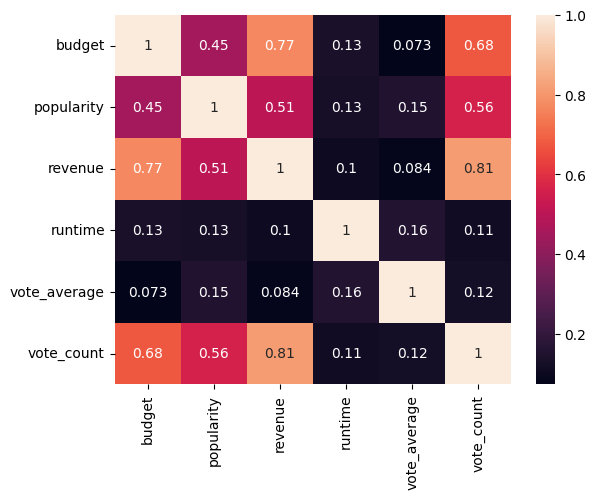

In [24]:
# evalute the correlation between all of the numeric columns
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
corr = movie_titles[numeric_cols].corr()
sns.heatmap(corr, annot=True)

## Ratings Data Analysis

In [6]:
ratings = pd.read_csv('ratings.csv')
print('Shape Ratings:\t{}'.format(ratings.shape))

# drop duplicate ratings
ratings = ratings.drop_duplicates(subset=['userId', 'movieId'], keep='last')
print('Shape Ratings:\t{}'.format(ratings.shape))

Shape Ratings:	(26024289, 4)
Shape Ratings:	(26024289, 4)


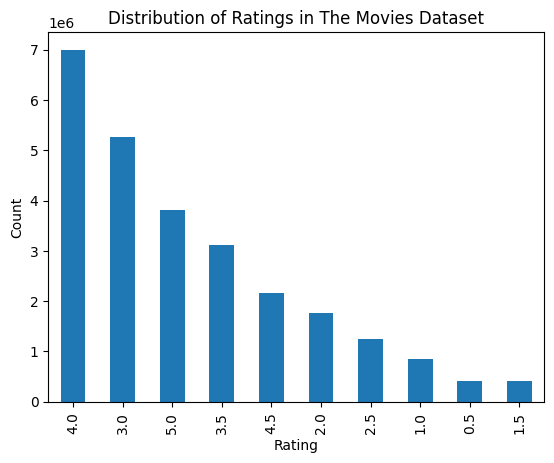

In [7]:
# let's look at the distribution of ratings
ratings['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings in The Movies Dataset')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [21]:
# let's look at the distribution of ratings
# print out the % of users that have rated less than 10 movies
print('Percentage of users that have rated less than 10 movies: {:.2f}%'.format(100*sum(ratings['userId'].value_counts() < 10)/len(ratings['userId'].unique())))
# print out the % of users that have rated less than 50 movies
print('Percentage of users that have rated less than 50 movies: {:.2f}%'.format(100*sum(ratings['userId'].value_counts() < 50)/len(ratings['userId'].unique())))
# print out the % of users that have rated less than 100 movies
print('Percentage of users that have rated less than 100 movies: {:.2f}%'.format(100*sum(ratings['userId'].value_counts() < 100)/len(ratings['userId'].unique())))
# mean median mode std
print(ratings['userId'].value_counts().describe())

Percentage of users that have rated less than 10 movies: 13.66%
Percentage of users that have rated less than 50 movies: 61.67%
Percentage of users that have rated less than 100 movies: 76.21%
count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
Name: userId, dtype: float64


A signficant amount of users have barely given a set of 10 ratings for movies, and a large majority have not given over 100 ratings. Clearly there a few users that are very invested in giving movie reviews/ratings, while the large majority of users barely have more than 30 reviews(very susceptible to outliers).

In [8]:
##### Ratings Per Movie #####
# Get data
data = ratings.groupby('movieId')['rating'].count().clip(upper=9999)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 10000,
                                  size = 100),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Movie (Clipped at 9999)',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)



##### Ratings Per User #####
# Get data
data = ratings.groupby('userId')['rating'].count().clip(upper=199)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 2),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 199)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)